# Final project

<b>Teams: </b> 3-4 people 

<b>Report Due Date: </b> 11:59pm Monday, April 25th (the night before the first set of presentations)

## Deliverables: 

1. Folder containing all the code files (no need to include data) used for project. Include a README.txt that briefly describes the functions/purposes of each file and the order you run them in. 
2. Prepare a report that addresses all the major questions (3 for undergraduate section and 4 for graduate section). The report should be focused on detailing the methods and the exploration of the dataset. Please include labeled figures to better visualize the results and data. 
3. Prepare a 10-15 minute presentation that summarizes the method used and the results. Include your slides in your submission.

## Introduction: 

Your collaborators are working on protocols to produce engineered mouse cardiomyocytes (CM) in vitro from fibroblasts. They have generated single-cell RNA-seq data and they are hoping you can help provide detailed hypotheses about the status of their cells and about potential protocol improvements. Their single-cell data are provided in the file folder [direct_conversion_data](https://compstemcellbio.s3.amazonaws.com/2022/final_project/direct_conversion_data_subsampled.zip). These data are in fact from [Stone et al](https://pubmed.ncbi.nlm.nih.gov/31271750/). Batched 1, 2, 3, 4, 5, and 6 represent timepoints -1, 1, 2, 3, 7, and 14. We have subsampled the data to 5,000 cells total, which we hope will simplify analysis for people with less RAM. If you want and you have sufficient computational power, you can also use the entire Stone dataset in [direct_conversion_data_full](https://compstemcellbio.s3.amazonaws.com/2022/final_project/direct_conversion_data_big.zip).

## Major Questions: 

<b>1. How pure are your engineered cardiomyocytes?</b> 

For estimating the success of engineered cardiomyocyte from Stone et al (similarity of expression profiles to cardiac muscle cells or fibroblast), perform in silico validation of the expression profiles with [reference dataset sampled from Tabula Muris](https://compstemcellbio.s3.amazonaws.com/2022/final_project/TM_FACS_heart.h5ad). Develop a method to perform comparison between the engineered CMs and reference dataset. 
- You may choose to use [pySCN](https://github.com/pcahan1/PySingleCellNet) to perform the assessment. 


In [2]:
import scanpy as sc
import pySingleCellNet as pySCN
import warnings

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy as sp
import numpy as np
import anndata

warnings.filterwarnings('ignore')

#### Read in both reference data and engineered dataset.

In [3]:
reference_data = sc.read_h5ad('TM_FACS_heart.h5ad')
reference_data.obs

,cell,cell_ontology_class,cell_ontology_id,cluster.ids,mouse.id,mouse.sex,plate.barcode,subtissue,tissue
cell,,,,,,,,,
A1.B000412.3_56_F.1.1,A1.B000412.3_56_F.1.1,endothelial cell,CL:0000115,2,3_56_F,F,B000412,RA,Heart
A1.B000633.3_56_F.1.1,A1.B000633.3_56_F.1.1,leukocyte,CL:0000738,4,3_56_F,F,B000633,RV,Heart
A1.B000634.3_56_F.1.1,A1.B000634.3_56_F.1.1,endothelial cell,CL:0000115,6,3_56_F,F,B000634,LA,Heart
A1.B002423.3_39_F.1.1,A1.B002423.3_39_F.1.1,fibroblast,CL:0000057,3,3_39_F,F,B002423,RV,Heart
A1.B002427.3_39_F.1.1,A1.B002427.3_39_F.1.1,myofibroblast cell,CL:0000186,7,3_39_F,F,B002427,LA,Heart
...,...,...,...,...,...,...,...,...,...
P9.MAA000586.3_8_M.1.1,P9.MAA000586.3_8_M.1.1,fibroblast,CL:0000057,0,3_8_M,M,MAA000586,RA,Heart
P9.MAA000587.3_8_M.1.1,P9.MAA000587.3_8_M.1.1,endothelial cell,CL:0000115,2,3_8_M,M,MAA000587,LV,Heart
P9.MAA000589.3_9_M.1.1,P9.MAA000589.3_9_M.1.1,endothelial cell,CL:0000115,2,3_9_M,M,MAA000589,LV,Heart


In [4]:
adata = sc.read_h5ad("direct_conversion_subsampled_5k.h5ad")
adata.obs

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
CGTTCTGTCATGCAAC-6,6,2990,8.003363,3192.841064,8.068979,6.108015,10.882674,18.767330,35.987287
TGAGCATGTCAGCTAT-5,5,3870,8.261268,3512.800781,8.164454,5.617473,10.030278,17.173657,32.631337
ATTGGTGGTGAGTGAC-2,2,2812,7.942007,3338.887695,8.113692,5.836763,10.565874,18.245293,35.495059
AACCATGGTACAAGTA-4,4,3133,8.050065,3337.686523,8.113333,6.015414,10.855748,18.416691,34.596811
GATCTAGAGATGCGAC-1,1,2981,8.000349,3419.704102,8.137602,5.728593,10.305606,17.683025,33.999350
...,...,...,...,...,...,...,...,...,...
GCAGCCACATTGGTAC-4,4,2700,7.901377,3137.520020,8.051507,6.345720,11.370976,19.371425,37.041649
CATTCGCAGATCCTGT-3,3,2883,7.966933,3053.349121,8.024322,6.859597,12.217943,20.269529,37.052554
CATCGGGGTCTCATCC-4,4,2295,7.738924,3250.425049,8.086848,5.832202,10.691060,18.643549,37.042548
GTTCTCGAGAGAACAG-4,4,3279,8.095599,3235.456055,8.082234,6.281128,11.342767,19.114254,35.246593


#### Split reference dataset into testing and training so that we are able to validate the model before we apply it to the engineered cardiomyocyte data.

In [5]:
expTrain, expVal = pySCN.splitCommonAnnData(reference_data, ncells=200,dLevel="cell_ontology_class")

myofibroblast cell : 
178
endocardial cell : 
165
leukocyte : 
523
endothelial cell : 
1177
fibroblast : 
2119
cardiac muscle cell : 
133
smooth muscle cell : 
42


#### Train our model on the reference training set.

In [6]:
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 100, nTrees = 1000 ,nTopGenePairs = 100, dLevel = "cell_ontology_class", stratify=True, limitToHVG=True)

HVG
Matrix normalized
There are  760  classification genes

cardiac muscle cell
endocardial cell
endothelial cell
fibroblast
leukocyte
myofibroblast cell
smooth muscle cell
There are 688 top gene pairs

Finished pair transforming the data



#### Validate our model with our testing set.

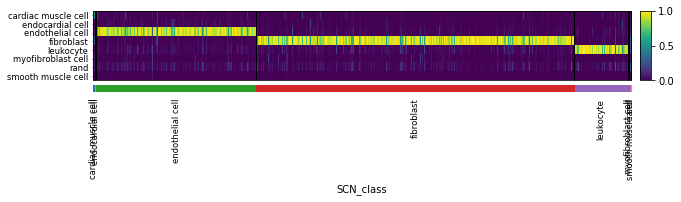

In [7]:
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)

ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

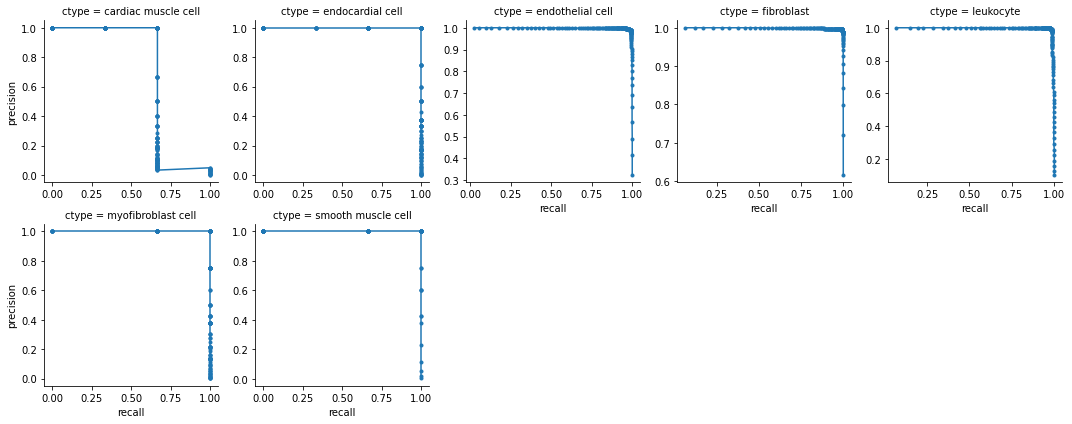

In [8]:
assessment =  pySCN.assess_comm(expTrain, adVal, resolution = 0.005, nRand = 0, dLevelSID = "cell", classTrain = "cell_ontology_class", classQuery = "cell_ontology_class")

pySCN.plot_PRs(assessment)
plt.show()

In [9]:
assessment['accuracy']

0.9851439182915506

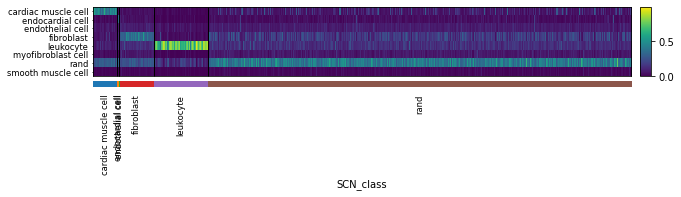

In [10]:
adCardiomyocyte = pySCN.scn_classify(adata, cgenesA, xpairs, tspRF, nrand = 0)

ax = sc.pl.heatmap(adCardiomyocyte, adCardiomyocyte.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

In [11]:
pySCN.add_classRes(adata, adCardiomyocyte)

In [12]:
engineered_cardiomyocytes = adata[adata.obs["SCN_class"] == "cardiac muscle cell"]
engineered_cardiomyocytes.obs

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,cardiac muscle cell,endocardial cell,endothelial cell,fibroblast,leukocyte,myofibroblast cell,rand,smooth muscle cell,SCN_class
CGTTCTGTCATGCAAC-6,6,2990,8.003363,3192.841064,8.068979,6.108015,10.882674,18.767330,35.987287,0.491,0.012,0.049,0.039,0.058,0.033,0.304,0.014,cardiac muscle cell
TCGCGAGGTTGCGCAC-6,6,3129,8.048788,3604.775879,8.190292,5.122358,9.327352,16.303029,32.179743,0.462,0.015,0.065,0.035,0.060,0.029,0.326,0.008,cardiac muscle cell
CTCATTATCTAAGCCA-6,6,3562,8.178358,3518.945312,8.166201,5.394646,9.655502,16.850956,32.989110,0.398,0.026,0.047,0.052,0.071,0.050,0.340,0.016,cardiac muscle cell
GATCTAGGTAAGTGTA-6,6,3233,8.081475,3475.179199,8.153689,5.457174,9.828575,17.085944,33.574657,0.419,0.031,0.054,0.065,0.109,0.011,0.306,0.005,cardiac muscle cell
ACGGGTCTCAGCGATT-6,6,3556,8.176673,3684.800781,8.212243,5.076208,9.127746,15.971834,31.697000,0.343,0.016,0.068,0.070,0.107,0.039,0.343,0.014,cardiac muscle cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACACCAATCAATAAGG-6,6,4043,8.304990,3613.012451,8.192574,5.294828,9.501559,16.558149,32.420525,0.510,0.017,0.058,0.038,0.055,0.034,0.269,0.019,cardiac muscle cell
GGGTTGCGTAGTACCT-6,6,2457,7.807103,3258.925781,8.089459,5.859981,10.569806,18.430123,36.361372,0.409,0.014,0.083,0.066,0.076,0.031,0.313,0.008,cardiac muscle cell
AAACGGGCAATTCCTT-6,6,3045,8.021585,3341.021973,8.114331,5.720262,10.382978,18.252576,35.848784,0.435,0.010,0.050,0.034,0.064,0.008,0.394,0.005,cardiac muscle cell
ACATACGTCAGGTTCA-6,6,3364,8.121183,3644.079346,8.201134,5.131870,8.882997,15.362300,30.447638,0.435,0.029,0.043,0.037,0.069,0.049,0.305,0.033,cardiac muscle cell


In [13]:
fibroblasts = adata[adata.obs["SCN_class"] == "fibroblast"]
fibroblasts.obs

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,cardiac muscle cell,endocardial cell,endothelial cell,fibroblast,leukocyte,myofibroblast cell,rand,smooth muscle cell,SCN_class
TTGAACGTCCAAGTAC-3,3,3769,8.234830,3598.134033,8.188449,5.438125,9.861487,17.005465,32.093293,0.028,0.075,0.092,0.310,0.096,0.088,0.266,0.045,fibroblast
TCGCGTTCAATAGCAA-1,1,2863,7.959975,3318.981689,8.107715,5.951339,10.844110,18.611585,35.166871,0.032,0.046,0.077,0.337,0.119,0.048,0.331,0.010,fibroblast
AGCGGTCGTATTCGTG-5,5,3470,8.152198,3626.726074,8.196362,5.011486,8.533024,14.473394,28.638186,0.046,0.064,0.054,0.396,0.078,0.068,0.263,0.031,fibroblast
GTAACGTCAATGGAAT-4,4,3183,8.065894,3346.763916,8.116048,5.921211,10.710175,18.227990,34.475570,0.032,0.081,0.082,0.347,0.117,0.054,0.276,0.011,fibroblast
CGACTTCGTTCGGGCT-5,5,4080,8.314097,3695.883545,8.215245,5.195539,9.363950,16.243966,31.556206,0.037,0.047,0.062,0.383,0.125,0.075,0.249,0.022,fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCCGAACAGCCTTGG-1,1,4023,8.300032,3554.216797,8.176171,5.588890,10.110237,17.260958,32.525331,0.021,0.039,0.070,0.520,0.076,0.048,0.185,0.041,fibroblast
CAGCGACCATGCGCAC-1,1,3963,8.285009,3563.983887,8.178915,5.488648,10.018336,17.379514,32.924170,0.036,0.057,0.108,0.334,0.127,0.072,0.244,0.022,fibroblast
ACACCCTGTAAGGGAA-1,1,3573,8.181441,3615.573486,8.193282,5.321133,9.711700,16.882654,32.236657,0.045,0.023,0.094,0.354,0.167,0.040,0.262,0.015,fibroblast
CAGCGACCATAGTAAG-2,2,4132,8.326759,3661.142334,8.205804,5.285581,9.551728,16.572232,31.777664,0.045,0.072,0.073,0.276,0.196,0.046,0.273,0.019,fibroblast


<b> 2. How mature are your engineered cardiomyocytes? </b>

Heart is one of the earliest organs to develop during embryogenesis. In mice, as early as embryonic day E7.0-7.5, convergence of lateral mesoderm domain called first heart field begins to beat. Cardiomyocytes rapidly proliferate up until E14, and then start maturation after. 

<figure>
    <img src="img/in_vivo_cardiomyocyte.png" width=500>
    <figcaption>Conceptual scheme of maturation phase of heart development. <a href="https://www.ahajournals.org/doi/10.1161/CIRCRESAHA.119.315862">Guo et al, 2020</a>
                                                                                                                         
</figcaption>
</figure>

Some of the major hallmarks of cardiomyocyte maturation include cell cycle arrest, multinucleation, growth by hypertrophy, transition to oxidative metabolism, and expression of mature sarcomeric contractile protein isoforms. [Padula et al, 2021](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8004589/) provides a review of the transcriptional regulations of cardiomyocyte maturation and the TF genes associated with CM maturation phenotypes.

To computationally estimate the maturity of engineered CM’s across different data sources, [Kannan et al](https://journals.plos.org/ploscompbiol/article/authors?id=10.1371/journal.pcbi.1009305) constructed a reference scRNA-seq resource for CM maturation by isolating CM cells from Myh6-Cre; mTmG (aMHC x mTmG) mice across 12 time points of CM maturation. 


<figure>
    <img src="img/postnatal_CM_maturation.png" width=600>
    <figcaption>A. Mouse model used to generate perinatal maturation reference scRNA-seq dataset. B. UMAP of maturation reference dataset. <a href="https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009305">Kannan et al, 2021</a>
                                                                                                                         
</figcaption>
</figure>

Kannan et al have provided a detailed protocol accompanied by software and extensive meta-analysis and validation for their entropy based method. Apply the protocol of Kannan et al. or use some other method to determine the maturation time point that the engineered CMs are most similar to using the [perinatal_reference_data](https://compstemcellbio.s3.amazonaws.com/2022/final_project/perinatal_reference_data.zip). As Kannan et al. do, you should only select the cells that were classified as cardiomyocyte in the previous steps. 

#### Function for correct reads mismapped to pseudogenes for mitochondrial genes. Two assumptions are maded.
- Assumption 1: All reads mapped to mt-Atp8 with its matched pseudogenes are assigned to mt-Apt6, since in the mitomap, all of pseudogenes and mitochondrial genes for mt-Atp8 gene belong to those for mt-Atp6.
- Assumption 2: Pseudogenes are dropped out from the Anndata Object.
- Since our group will correct gene names for human CMs in Part4, this function does not take the difference of gene names for mouse and human into consideration.

In [16]:
def mito_correct(mitomap, anndata, species = "mouse"):
    """ 
    Correct reads mapped into mitochondrial genes based on similar pseudogenes
    
    Parameters
    ----------
    :type map: DataFrame
    :type anndata: anndata._core.anndata.AnnData
    :type species: str
    
    """
    expression_matrix = anndata.to_df()

    for i, mito_gene in enumerate(mitomap.index.to_list()):
        if mito_gene in expression_matrix.columns:
            mapped_genes = mitomap.iloc[i,0].split(";")
                
            mapped_common_genes = list(set(mapped_genes).intersection(expression_matrix.columns))
            pseudogenes = [gene for gene in mapped_common_genes if gene != mito_gene]
        
            if pseudogenes and mito_gene != "mt-Atp8":

                mito_index = expression_matrix.columns.get_loc(mito_gene)
                mapped_gene_index = expression_matrix.columns.get_indexer(mapped_common_genes)
            
                anndata.X[:,mito_index] = anndata.X[:,mapped_gene_index].sum(axis = 1)
                keep = np.array([True if gene not in pseudogenes else False for gene in anndata.var_names ])
                anndata = anndata[:,keep].copy()
                    
    
    return anndata

#### mitomap is provided by Eric.

In [17]:
perinatal_reference = sc.read_h5ad("Kannan_perinatal_reference.h5ad")
mitomap = pd.read_csv("kannan et al mitomap.txt", sep = "\t")

#### Correct reads mapped to mito-chondrial genes for reference data

In [18]:
perinatal_reference = mito_correct(mitomap, perinatal_reference)

In [19]:
perinatal_reference.obs

,i7,cellbarcode,column,timepoint,genes,umis,ERCC_percent,reads
AAGAGGCAAAAGTT,AAGAGGCA,AAAGTT,2,e18,3634,13286,0.135481,32540
AAGAGGCAATATAG,AAGAGGCA,ATATAG,1,e14,6540,33196,1.159778,74811
AAGAGGCAATCAAA,AAGAGGCA,ATCAAA,2,e18,4768,23413,0.119592,57580
AAGAGGCAATGAAT,AAGAGGCA,ATGAAT,3,p0,7775,55248,0.642557,128987
AAGAGGCACCCACG,AAGAGGCA,CCCACG,1,e14,5524,25256,1.041337,71429
...,...,...,...,...,...,...,...,...
GGACTCCTTCTGCA,GGACTCCT,TCTGCA,4,p4,7533,38004,0.902537,95643
GTAGAGGAAAGATT,GTAGAGGA,AAGATT,4,p4,6199,28008,2.038703,66286
TAGGCATGTTGAAA,TAGGCATG,TTGAAA,5,p8,4888,21802,1.165031,63119
TCCTGAGCCCAACC,TCCTGAGC,CCAACC,5,p8,4642,22618,0.353701,77349


#### Remove all ribo-genes

In [20]:
ribo_genes = perinatal_reference.var_names.str.startswith(("Rpl","Rps"))
keep = np.invert(ribo_genes)
perinatal_reference = perinatal_reference[:,keep].copy()

In [21]:
perinatal_reference.layers["spliced"] = perinatal_reference.X
perinatal_reference.layers["unspliced"] = perinatal_reference.X
import scvelo as scv
scv.pp.moments(perinatal_reference, n_pcs = 30, n_neighbors = 30)


Normalized count data: X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


#### Run cytotrace for computing direct transition probabilities based on KNN graph

In [22]:
from cellrank.tl.kernels import CytoTRACEKernel

ctk = CytoTRACEKernel(perinatal_reference)

In [23]:
perinatal_reference.raw = perinatal_reference
sc.pp.log1p(perinatal_reference)

#### Find top 10000 highly variable genes in the reference data and extract expression values based on just normaliazed results

In [24]:
sc.pp.highly_variable_genes(perinatal_reference, min_mean = 0.0125, max_mean = 4, min_disp = 0.25)
top_genes = perinatal_reference.var[perinatal_reference.var["highly_variable"] == True].sort_values(by = ['dispersions_norm'], ascending = False).iloc[0:10000].index
keep = [True if gene in top_genes else False for gene in perinatal_reference.var_names]
top_genes_reference = perinatal_reference.raw.to_adata()[:,keep].copy()

#### Function for Entropy calculation

In [25]:
def calculate_entropy(anndata, log_transformation = None):
    Entropy = []
    for i in range(anndata.n_obs):
        if log_transformation:
            prob = 10**top_genes_CMs.X[i, :] / sum(10**top_genes_CMs.X[i, :])
        else:   
            prob = anndata.X[i, :] / sum(anndata.X[i, :])
        prob = prob[prob!= 0]
        entropy = np.sum(np.multiply(-prob, np.log(prob)))
        Entropy.append(entropy)
    return Entropy

#### Caculate the entropy for the reference data and visualize the results

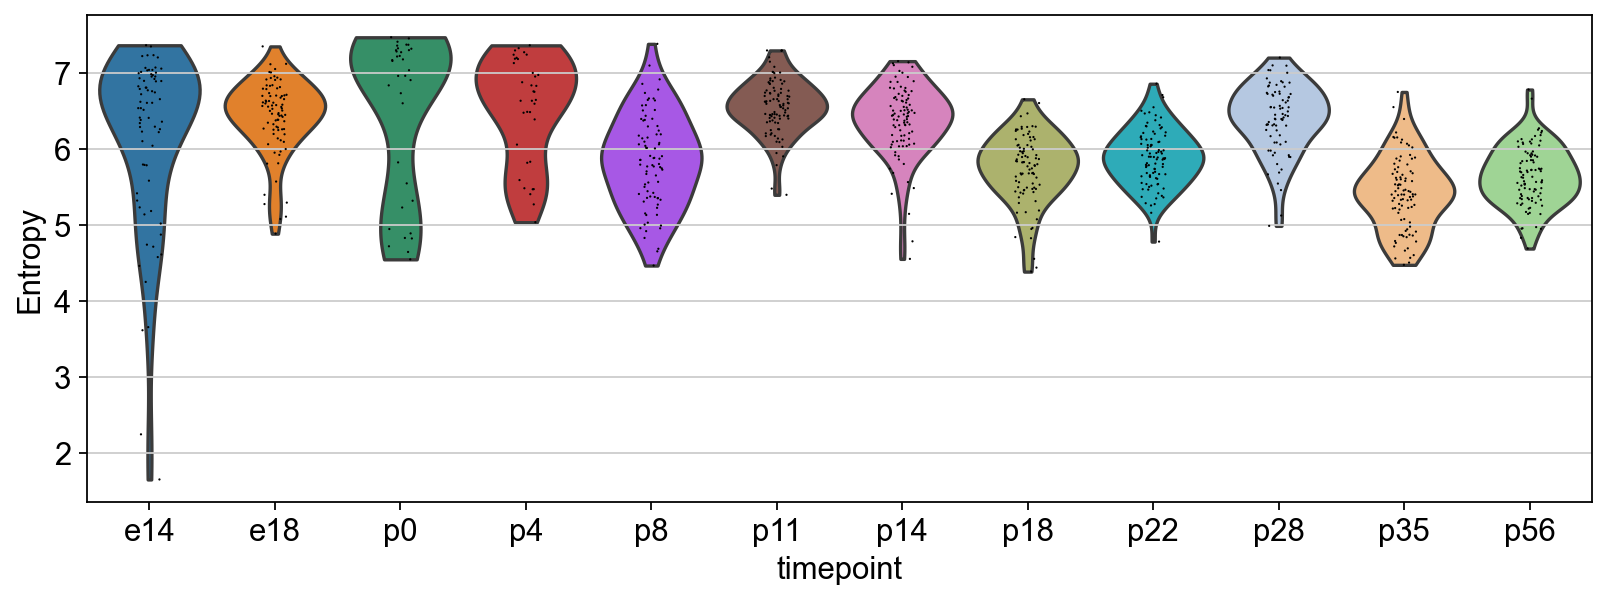

In [26]:
Entropy_reference = calculate_entropy(top_genes_reference)
perinatal_reference.obs['Entropy'] = Entropy_reference
sc.set_figure_params(figsize="10, 4")
sc.pl.violin(perinatal_reference, "Entropy", groupby="timepoint")

#### Entropy gradually decrease as CMs matures because they tend to reduce the expression of immature gene pathways in the process of maturation.

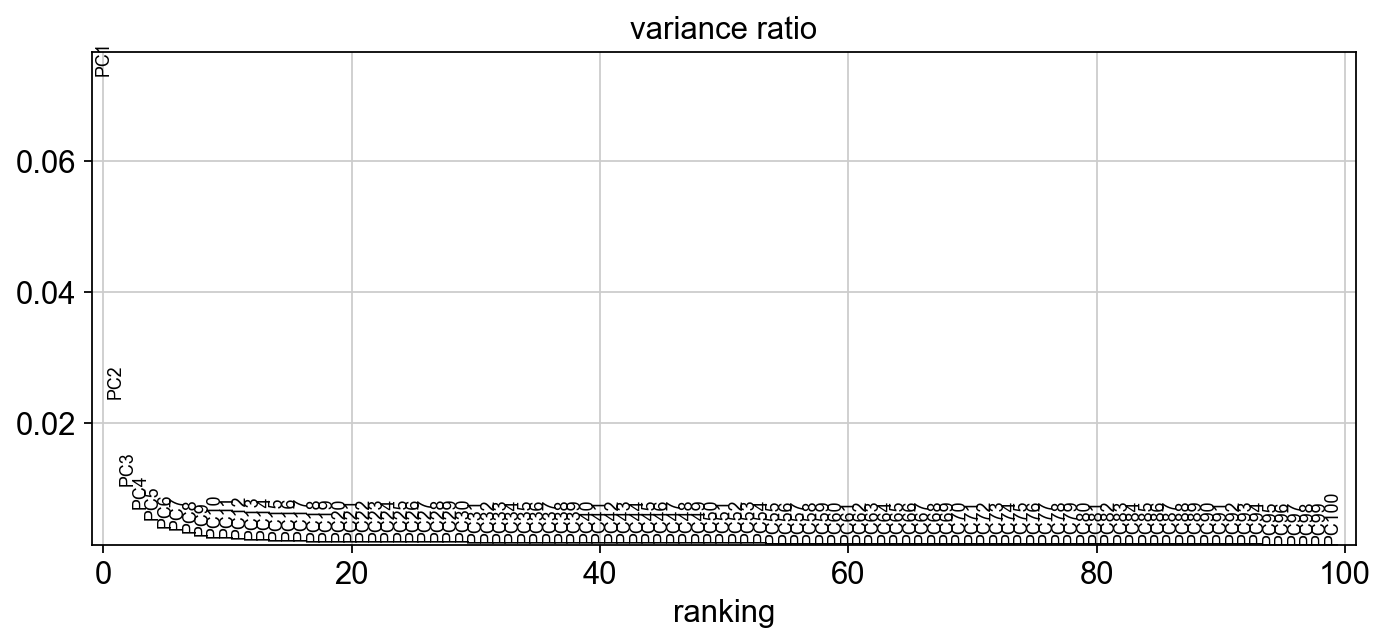

In [27]:
sc.tl.pca(perinatal_reference, n_comps = 100, use_highly_variable = False)
sc.set_figure_params(figsize = "10, 4")
sc.pl.pca_variance_ratio(perinatal_reference ,100, )

In [28]:
n_pcs = 15
n_neighbors = 15
sc.pp.neighbors(perinatal_reference, n_neighbors = n_neighbors, n_pcs = n_pcs)

In [29]:
sc.tl.diffmap(perinatal_reference)

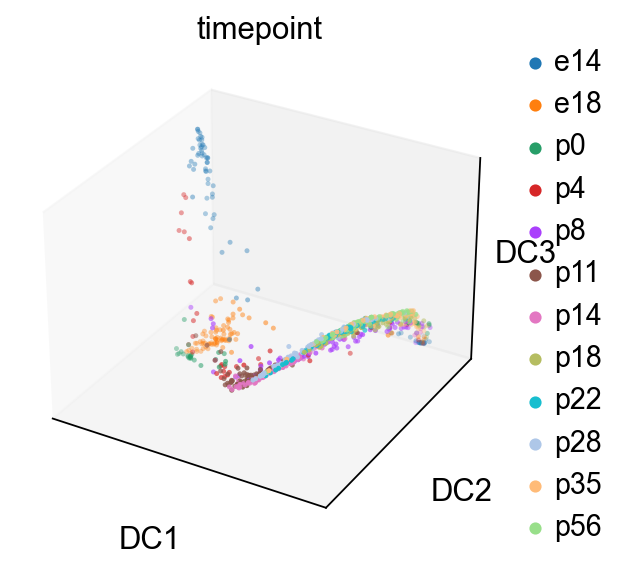

In [30]:
sc.pl.diffmap(perinatal_reference, color="timepoint", projection = "3d")

#### Choose e14 timepoint as the root cells based on the maturation process of CMs for comput diffusion pseudotime

In [31]:
perinatal_reference.uns['iroot'] = np.flatnonzero(perinatal_reference.obs['timepoint']  == 'e14')[0]

In [32]:
sc.tl.dpt(perinatal_reference, n_branchings = 1)

Visulize the diffuision pseudotime of each timepoint for reference data

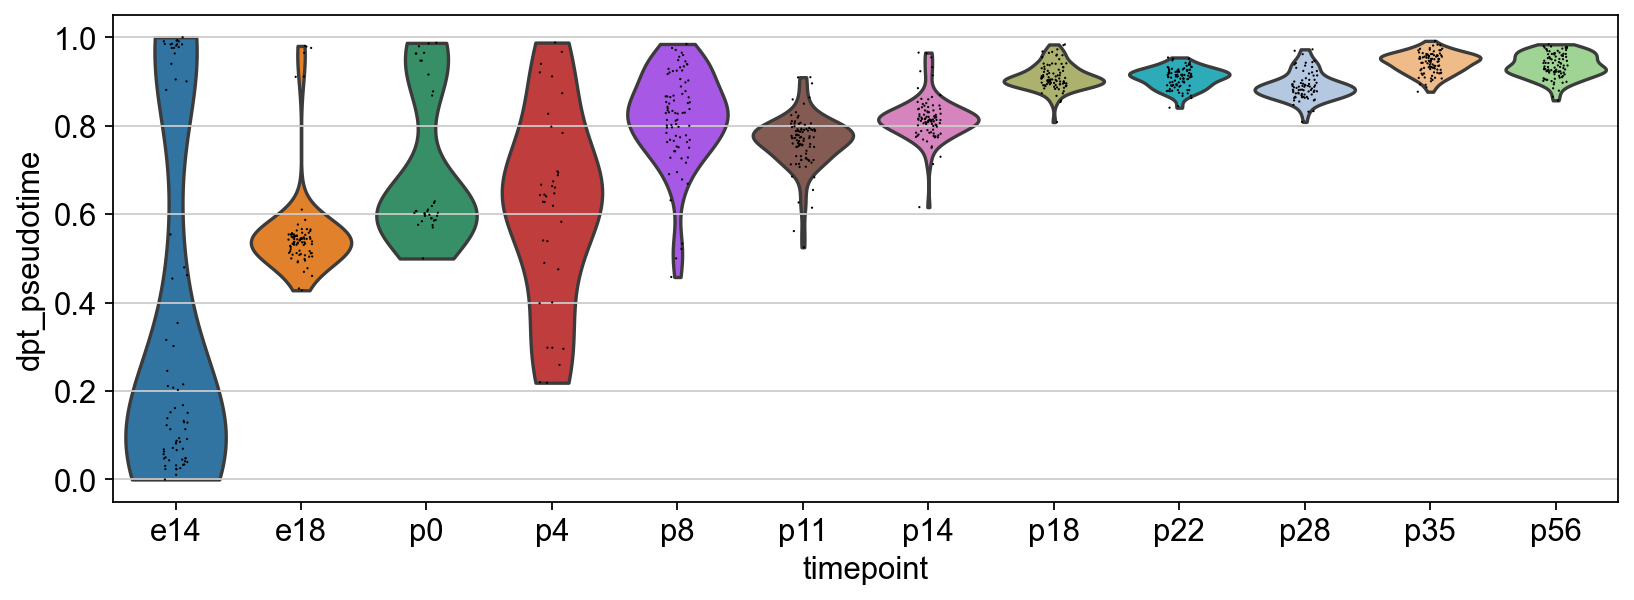

In [33]:
sc.pl.violin(perinatal_reference, "dpt_pseudotime", groupby="timepoint")

#### Visulize the cytotrace pseudotime of each timepoint for reference data

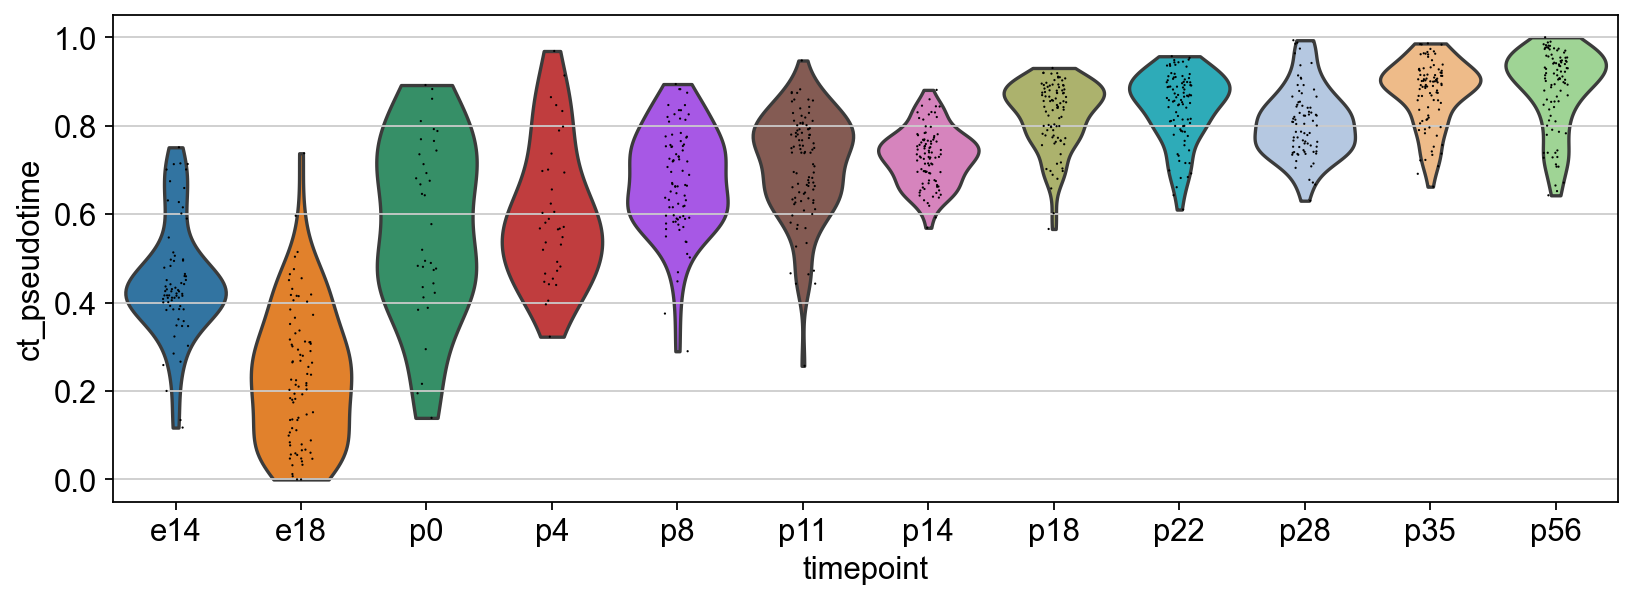

In [34]:
sc.pl.violin(perinatal_reference, "ct_pseudotime", groupby="timepoint")

#### Entropy model could be validated by comparing the results of diffusion pseudtime, cytotrace pseudotime with entropy score. Acctually diffusion psedutime works better.

#### Extract cardiomyocyte based on the results of classication process in Part 1.

In [35]:
cardiomyocyte_barcode = adCardiomyocyte.obs.loc[adCardiomyocyte.obs['SCN_class'] == 'cardiac muscle cell', :].copy().index.to_list()
adata.obs['cell_type'] = None
adata.obs.loc[adata.obs.index.isin(cardiomyocyte_barcode), 'cell_type'] = 'cardiomyocyte'
engineered_cardiomyocyte = adata[adata.obs['cell_type'] == 'cardiomyocyte', :].copy()

#### Correct reads mapped to mitochondrial genes for engineered cardiomyocytes

In [36]:
engineered_cardiomyocyte = mito_correct(mitomap, engineered_cardiomyocyte)

In [37]:
engineered_cardiomyocyte

AnnData object with n_obs × n_vars = 222 × 33593
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'cardiac muscle cell', 'endocardial cell', 'endothelial cell', 'fibroblast', 'leukocyte', 'myofibroblast cell', 'rand', 'smooth muscle cell', 'SCN_class', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'batch_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [38]:
engineered_cardiomyocyte.var['mt']= engineered_cardiomyocyte.var_names.str.startswith(("mt-"))
engineered_cardiomyocyte.var['ribo'] = engineered_cardiomyocyte.var_names.str.startswith(("Rps","Rpl"))

In [39]:
sc.pp.calculate_qc_metrics(engineered_cardiomyocyte, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

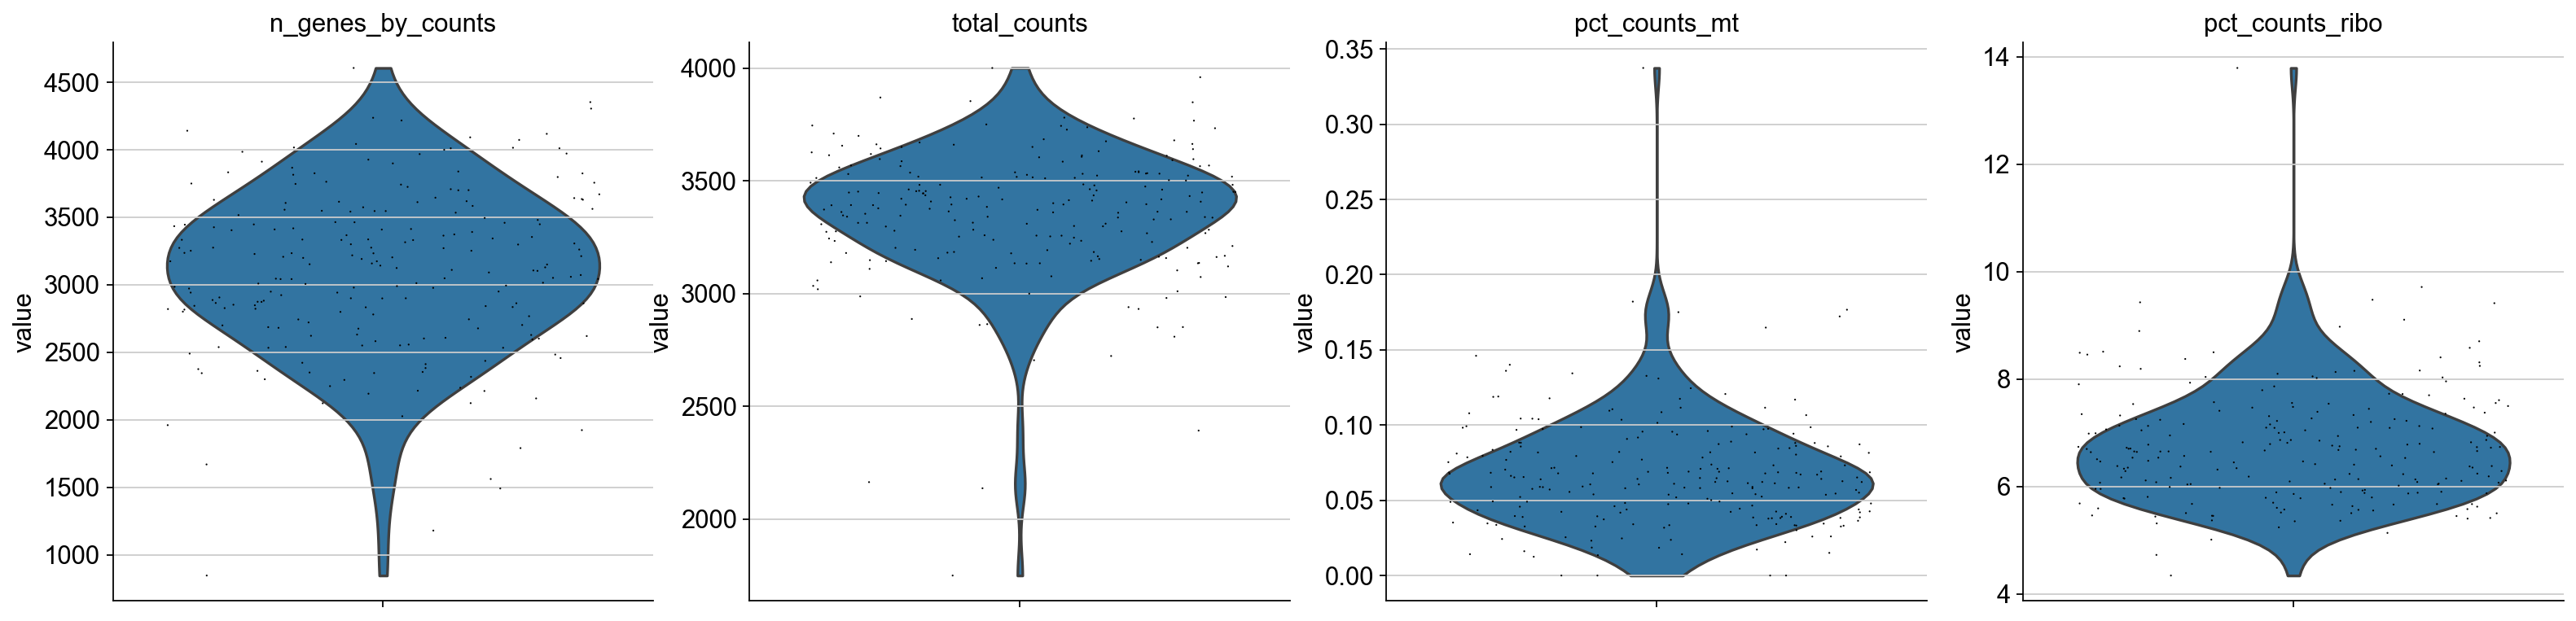

In [40]:
axs = sc.pl.violin(engineered_cardiomyocyte, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

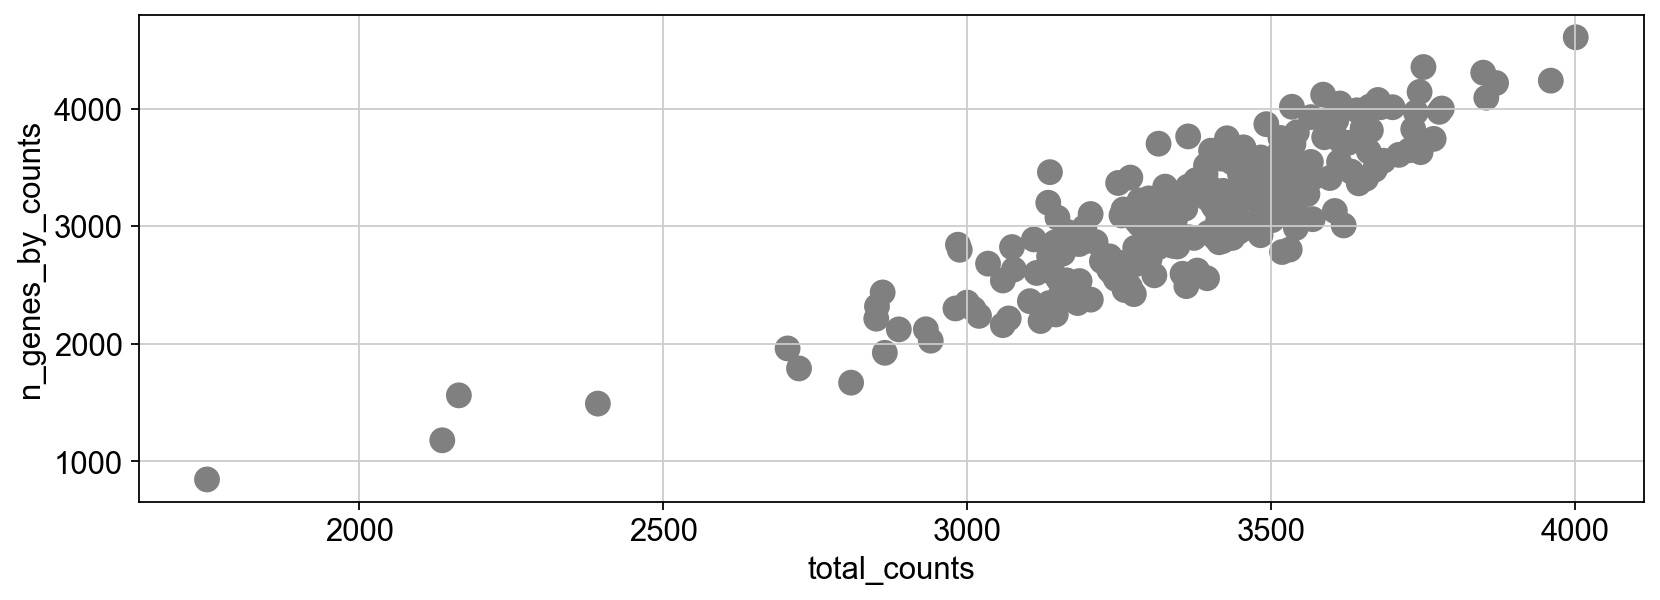

In [41]:
sc.pl.scatter(engineered_cardiomyocyte, x='total_counts', y='n_genes_by_counts')

In [42]:
gThresh = 5
sc.pp.filter_genes(engineered_cardiomyocyte, min_cells=gThresh)

#### Since this dataset have already been preprocessed, we don't perform more quality control

#### Remove ribo-genes

In [43]:
ribo_genes = engineered_cardiomyocyte.var_names.str.startswith(("Rpl","Rps"))
keep = np.invert(ribo_genes)
engineered_cardiomyocyte = engineered_cardiomyocyte[:,keep].copy()

In [44]:
engineered_cardiomyocyte.layers["spliced"] = engineered_cardiomyocyte.X
engineered_cardiomyocyte.layers["unspliced"] = engineered_cardiomyocyte.X
scv.pp.moments(engineered_cardiomyocyte, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


#### Run cytotrace

In [45]:
ctk = CytoTRACEKernel(engineered_cardiomyocyte)

In [46]:
top_genes = engineered_cardiomyocyte.var[engineered_cardiomyocyte.var["highly_variable"] == True].sort_values(by = ['dispersions_norm'], ascending = False).iloc[0:5000].index
keep = [True if gene in top_genes else False for gene in engineered_cardiomyocyte.var_names]
top_genes_CMs= engineered_cardiomyocyte[:,keep].copy()

Entropy_CMs = []
for i in range(top_genes_CMs.n_obs):
    prob = 10**top_genes_CMs.X[i, :] / sum(10**top_genes_CMs.X[i, :])
    prob = prob[prob!= 0]
    entropy = np.sum(np.multiply(-prob, np.log(prob)))
    Entropy_CMs.append(entropy)


engineered_cardiomyocyte.obs['Entropy'] = Entropy_CMs
sc.set_figure_params(figsize="10, 4")
sc.pl.violin(engineered_cardiomyocyte, "Entropy", groupby="batch")

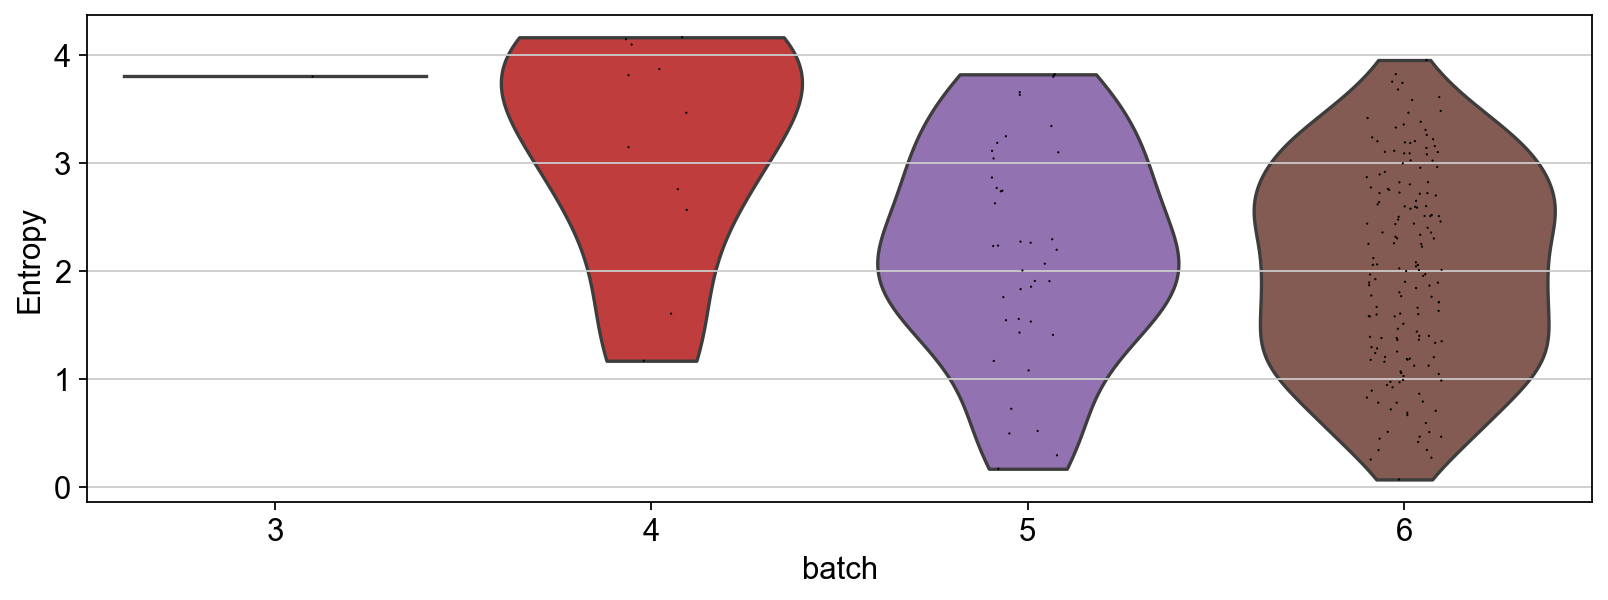

In [47]:
Entropy_CMs = calculate_entropy(top_genes_CMs, log_transformation = True)
engineered_cardiomyocyte.obs['Entropy'] = Entropy_CMs
sc.set_figure_params(figsize="10, 4")
sc.pl.violin(engineered_cardiomyocyte, "Entropy", groupby="batch")

### The entropy score shows the trend of maturation but the ranges of entropy scores for all batches don't match any ranges of those scores calculated for reference data.

In [48]:
n_pcs = 20
n_neighbors = 15
sc.pp.neighbors(engineered_cardiomyocyte, n_neighbors=n_neighbors, n_pcs=n_pcs)

In [49]:
sc.tl.diffmap(engineered_cardiomyocyte)

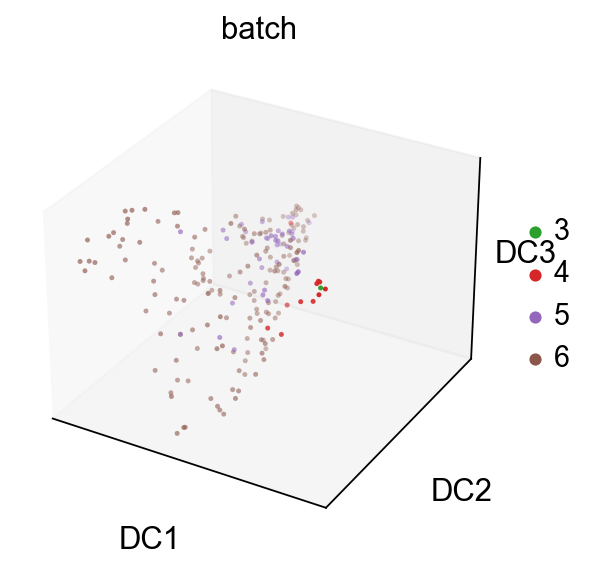

In [50]:
sc.pl.diffmap(engineered_cardiomyocyte, color="batch", projection = "3d")

#### Select cells belonging to batch 3 as root cells based on instructions

In [51]:
engineered_cardiomyocyte.uns['iroot'] = np.flatnonzero(engineered_cardiomyocyte.obs['batch']  == '3')[0]

In [52]:
sc.tl.dpt(engineered_cardiomyocyte, n_branchings = 1)

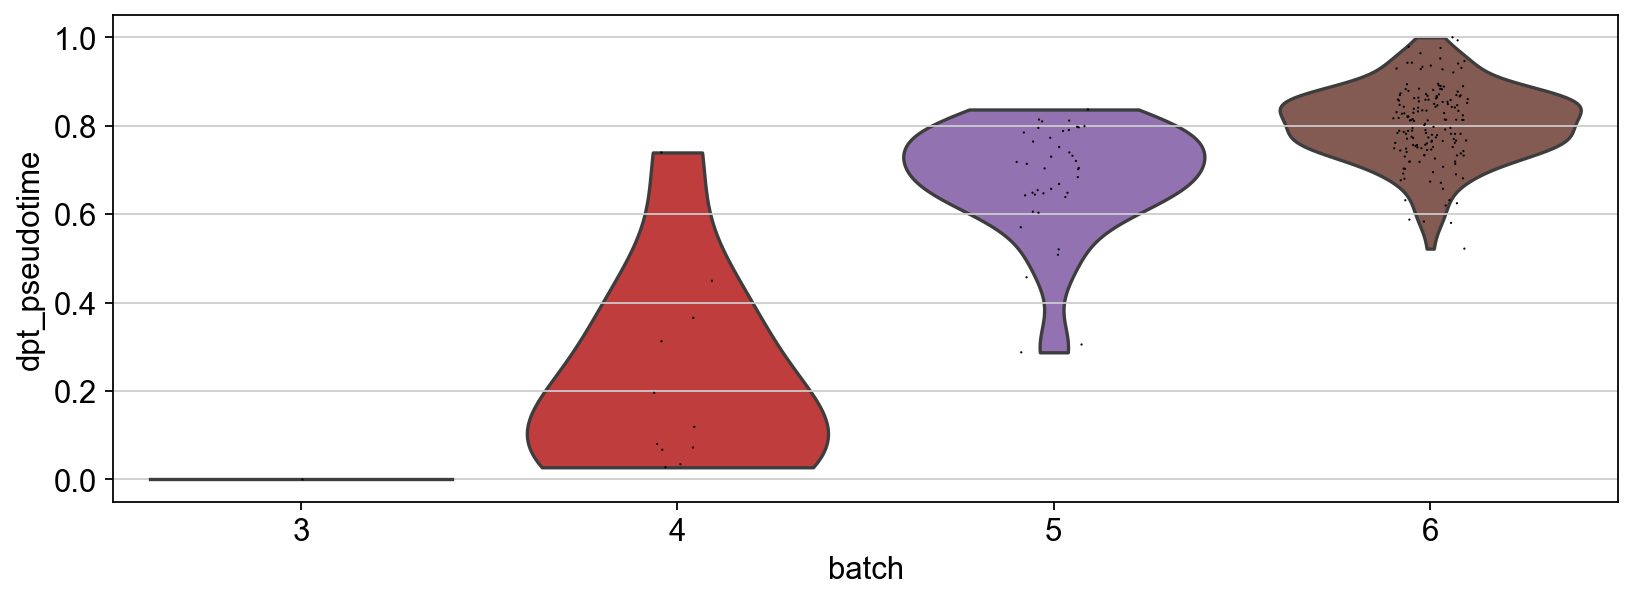

In [53]:
sc.pl.violin(engineered_cardiomyocyte, "dpt_pseudotime", groupby="batch")

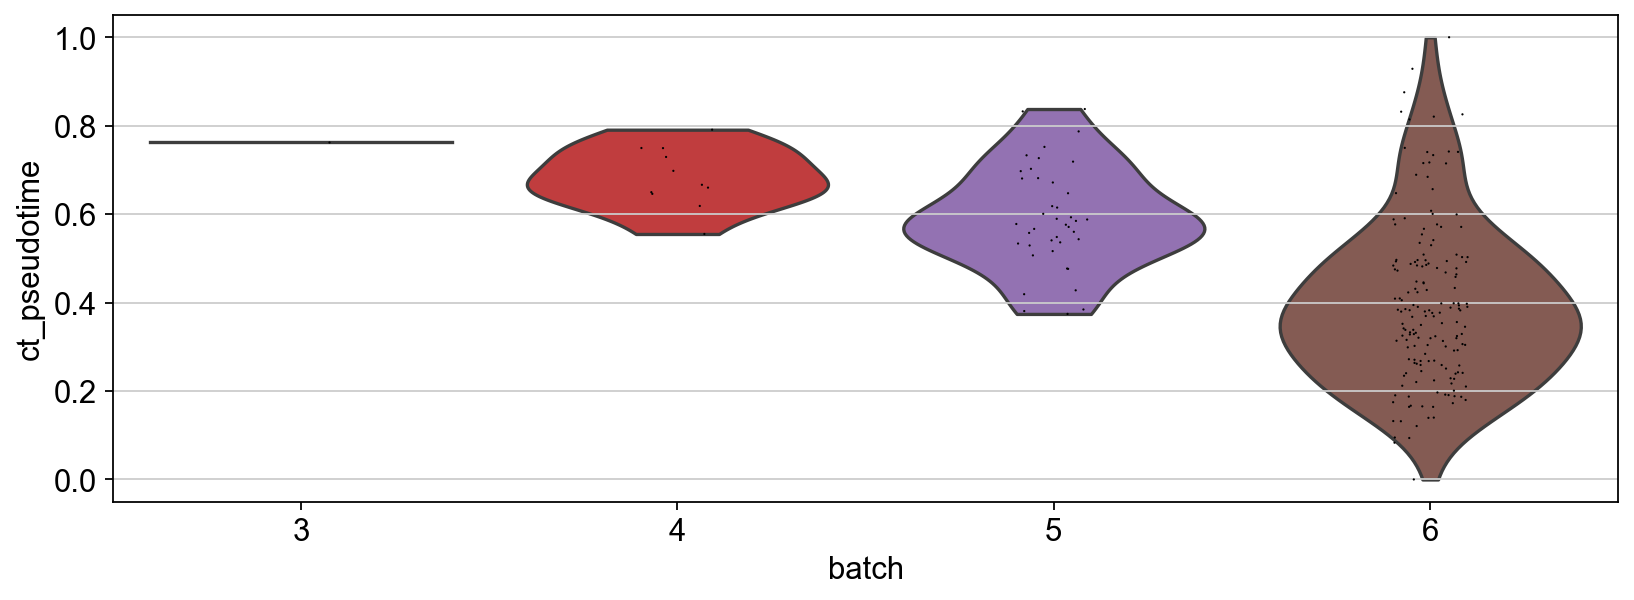

In [54]:
sc.pl.violin(engineered_cardiomyocyte, "ct_pseudotime", groupby="batch")

#### However, diffusion pseudotime displays the maturation process but cytotrace pseudotime show opposite trend that is contradictory to the information in the instructions.

<b>3. What genetic alterations could improve your engineered cardiomyocytes?</b>

Estimating maturity is useful as a metric, but it does not provide an immediate path forward in the form of specific hypotheses for how to improve the engineered CMs. Your collaborators want to identify candidate TFs that they could overexpress or knock out to further enhance differentiation. Set up an in silico screen with CellOracle. The essential components are:
1. A training dataset. To ensure relevant cell types are represented, we recommend the in vivo perinatal CM development timecourse from Kannan et al., available in file folder [perinatal_reference_data](https://compstemcellbio.s3.amazonaws.com/2022/final_project/perinatal_reference_data.zip). 

2. An evaluation dataset. How well do CellOracle’s predicted fold changes correspond to what would actually happen? You can test this using a cardiomyocyte-specific knockout of the transcription factor Prdm16, which was assayed with scRNA-seq at embryonic day 13.5 in figure 6 of [Wu et al. 2022.](https://pubmed.ncbi.nlm.nih.gov/34915728/). These data have been downsampled to 5,000 barcodes and are available in the [wu_prdm16 folder](https://compstemcellbio.s3.amazonaws.com/2022/final_project/wu_prdm16.zip). There are two biological replicates each of control and knockout samples.

3. A base GRN. To obtain better performance across a wider range of testable perturbations, compare three options for the base network: completely dense (all possible connections), CellOracle’s default, and a custom base network derived from motif analysis of the ATAC-seq data in Figure 3 of Stone et al, available in <b>direct_conversion_data/GSE130806_Bulk_Atac_Count_Data.bed</b>. As controls, also include randomly generated networks matching the density of the motif-derived networks. There is a tutorial on motif analysis for CellOracle [here](https://morris-lab.github.io/CellOracle.documentation/notebooks/01_ATAC-seq_data_processing/option2_Bulk_ATAC-seq_data/01_preprocess_Bulk_ATAC_seq_peak_data.html). If your team has 4 or fewer members, you can skip this item. Just use the default base GRN provided with CellOracle. 

4. A summary metric. Though it’s very useful to have per-gene fold change predictions, they are hard to understand and hard to rank by usefulness. Develop a method to rank the predicted transcriptomes by how useful the perturbations will be for engineering cardiomyocytes.
    - Look at what TF perturbation would drive the maturation of cardiomyocytes and whether or not it would specifically be beneficial to drive the maturation of cells from directed conversion experiment.

## Major Questions (Graduate Section Only): 

### Option 1: 

<b>What non-genetic cues might improve you engineered cardiomyocytes?</b>

Aside from overexpressing transcription factors, another method of optimizing cell fate engineering is to use drug compounds or morphogens that target signaling pathways with important roles in embryonic development. (Box 1 gives some context on morphogens.) Modify or repurpose CellOracle to allow predictions of transcriptomic changes due to activation or repression of signaling pathways. Ideally, any new method of this sort would be tested on a prediction task relevant to in vitro directed differentiation. One potential test dataset is [this screen of 320 FDA-approved drugs for maturation of mouse colon organoids](https://www.sciencedirect.com/science/article/pii/S2211124721003405), available in the [compound_screening folder](https://compstemcellbio.s3.amazonaws.com/2022/final_project/compound_screen.zip). In each sample, the full transcriptome is not measured, but roughly 200 genes are measured, which provides enough information to test detailed predictions from an extension of CellOracle. If your solution would benefit from a full-transcriptome intestinal organoid dataset, we suggest the mouse intestinal organoid scRNA-seq dataset from [Grün et al. 2015](https://www.nature.com/articles/nature14966), which uses the same protocol to culture organoids. This dataset is available in the [grun_organoids folder](https://compstemcellbio.s3.amazonaws.com/2022/final_project/grun_organoids.zip).


***

<b>Box 1: Morphogens.</b> Morphogens are diffusible signals that play a role in patterning of tissues and organs during development. One example of a morphogen is Sonic HedgeHog (SHH). It is a soluble protein. It is important in dorsoventral patterning of vertebrate embryos. During formation of the spinal cord, a flat layer of ectoderm folds inward to form a tube. SHH is secreted from a plate of cells on the innermost side of the tube. It diffuses towards the outermost side. As it reaches the cells that will respond to it, it interacts with membrane-bound protein complexes. Through a moderately complicated series of events, it eventually activates transcription factors from the Gli family. Depending on the dose, different target genes are activated. These target genes repress each others’ expression, giving rise to sharp boundaries between discrete zones with distinct transcriptional profiles. These boundaries remain stable when SHH is removed; the cells are committed to their respective fates. Morphogens provide similar spatial cues throughout development of diverse body structures in diverse organisms. 

<b>Morphogen diversity.</b> Morphogens can be soluble proteins like SHH. They can also be small molecules. An example of a natural small-molecule morphogen is retinoic acid, and an example of a natural small-molecule inhibitor of SHH is cyclopamine. (Cyclopamine occurs in plants as a poison, helping defend against herbivorous animals.) Morphogens are often discussed in terms of “pathways”, which describe how the signal reaches the nucleus starting from outside the cell. Other examples of morphogen pathways are Notch, Wnt, bone morphogenic protein (BMP), and transforming growth factor beta (TGF-beta). Each of these has distinct roles, mechanisms, and quirks. There is a surprisingly small collection of pathways that are re-used in many contexts during development of animals with bilateral symmetry. These receive special attention in stem cell biology. But, it is also possible to screen drugs or compounds with no known role in development; they may still prove useful in directed differentiation protocols.

<figure>
    <img src="img/morphogen_image1.png" width=300>
    <figcaption>Difference classes of spinal neurons are patterned by different doses of SHH over a fairly short (<24hr) time interval. Image credit: https://cshperspectives.cshlp.org/content/1/2/a002014/F2.expansion.html
                                                                                                                         
</figcaption>
</figure>

<figure>
    <img src="img/morphogen_image2.png" width=300>
    <figcaption>How the SHH signal is transduced into the nucleus to alter transcription. 

Image credit: https://www.frontiersin.org/articles/10.3389/fmolb.2021.711710/full

</figcaption>
</figure>

***

### Option 2: 

<b>How can your computational methods be translated to help engineer human cardiomyocytes? </b>

Questions 1-3 focus on mouse cells, but your collaborators are ultimately interested in translational and medical research, so they need human CM’s. They have generated preliminary data on directed differentiation of human cells, available in [human_engineered_cardiomyocytes](https://compstemcellbio.s3.amazonaws.com/2022/final_project/human_engineered_cardiomyocytes.zip) (in fact, these data are from [Giacomelli et al.](https://www.cell.com/cell-stem-cell/fulltext/S1934-5909(20)30202-2)). Apply the same assessment and TF screening methods to human iPSCs.

In [55]:
adTrain = sc.read("TM_FACS_heart.h5ad")
adTrain

AnnData object with n_obs × n_vars = 4337 × 23433
    obs: 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cluster.ids', 'mouse.id', 'mouse.sex', 'plate.barcode', 'subtissue', 'tissue'

In [56]:
adQuery = sc.read("hIPSC_CM_orlova_GSM4443382.h5ad")
adQuery

AnnData object with n_obs × n_vars = 3650 × 33694
    var: 'gene_ids'

In [57]:
list_names = list(adQuery.var_names)
lower_list = [each_string.lower() for each_string in list_names]
adQuery.var_names = lower_list

In [58]:
list_names = list(adTrain.var_names)
lower_list = [each_string.lower() for each_string in list_names]
adTrain.var_names = lower_list

In [59]:
genesTrain = adTrain.var_names
genesQuery = adQuery.var_names

cgenes = genesTrain.intersection(genesQuery)
print(len(cgenes))

adTrain = adTrain[:,cgenes]
adQuery = adQuery[:,cgenes].copy()
adQuery

14823


AnnData object with n_obs × n_vars = 3650 × 14823
    var: 'gene_ids'

In [60]:
adQuery.var

,gene_ids
a1bg,ENSG00000121410
a1cf,ENSG00000148584
a2m,ENSG00000175899
a3galt2,ENSG00000184389
a4galt,ENSG00000128274
...,...
zyg11a,ENSG00000203995
zyg11b,ENSG00000162378
zyx,ENSG00000159840
zzef1,ENSG00000074755


In [61]:
expTrain.obs

,cell,cell_ontology_class,cell_ontology_id,cluster.ids,mouse.id,mouse.sex,plate.barcode,subtissue,tissue,NaN
cell,,,,,,,,,,
A1.B000634.3_56_F.1.1,A1.B000634.3_56_F.1.1,endothelial cell,CL:0000115,6,3_56_F,F,B000634,LA,Heart,A1.B000634.3_56_F.1.1
A1.B002427.3_39_F.1.1,A1.B002427.3_39_F.1.1,myofibroblast cell,CL:0000186,7,3_39_F,F,B002427,LA,Heart,A1.B002427.3_39_F.1.1
A1.B002428.3_38_F.1.1,A1.B002428.3_38_F.1.1,endocardial cell,CL:0002350,8,3_38_F,F,B002428,LA,Heart,A1.B002428.3_38_F.1.1
A1.MAA000398.3_9_M.1.1,A1.MAA000398.3_9_M.1.1,fibroblast,CL:0000057,1,3_9_M,M,MAA000398,LA,Heart,A1.MAA000398.3_9_M.1.1
A1.MAA100037.3_10_M.1.1,A1.MAA100037.3_10_M.1.1,cardiac muscle cell,CL:0000746,9,3_10_M/3_11_M,M,MAA100037,Unknown,Heart,A1.MAA100037.3_10_M.1.1
...,...,...,...,...,...,...,...,...,...,...
P8.B002421.3_39_F.1.1,P8.B002421.3_39_F.1.1,endothelial cell,CL:0000115,2,3_39_F,F,B002421,LV,Heart,P8.B002421.3_39_F.1.1
P8.B002428.3_38_F.1.1,P8.B002428.3_38_F.1.1,endocardial cell,CL:0002350,8,3_38_F,F,B002428,LA,Heart,P8.B002428.3_38_F.1.1
P8.MAA000586.3_8_M.1.1,P8.MAA000586.3_8_M.1.1,endocardial cell,CL:0002350,8,3_8_M,M,MAA000586,RA,Heart,P8.MAA000586.3_8_M.1.1


In [62]:
expTrain, expVal = pySCN.splitCommonAnnData(adTrain, ncells=200,dLevel="cell_ontology_class")
adQuery.obs

C:\Users\Sarah\anaconda3\envs\stem_cell_2\lib\site-packages\pySingleCellNet\utils.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[cellid] = adata.obs.index


myofibroblast cell : 
178
endocardial cell : 
165
leukocyte : 
523
endothelial cell : 
1177
fibroblast : 
2119
cardiac muscle cell : 
133
smooth muscle cell : 
42


""
AAACCTGAGAAGGTTT-1
AAACCTGAGCATCATC-1
AAACCTGCAGACGTAG-1
AAACCTGGTCGTGGCT-1
AAACCTGGTTTCGCTC-1
...
TTTGGTTTCTCTGAGA-1
TTTGGTTTCTGTGCAA-1
TTTGTCAGTCTCCACT-1
TTTGTCATCCTACAGA-1


In [63]:
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 0, nTrees = 1000 ,nTopGenePairs = 100, dLevel = "cell_ontology_class", stratify=True, limitToHVG=True)

HVG
Matrix normalized
There are  718  classification genes

cardiac muscle cell
endocardial cell
endothelial cell
fibroblast
leukocyte
myofibroblast cell
smooth muscle cell
There are 693 top gene pairs

Finished pair transforming the data



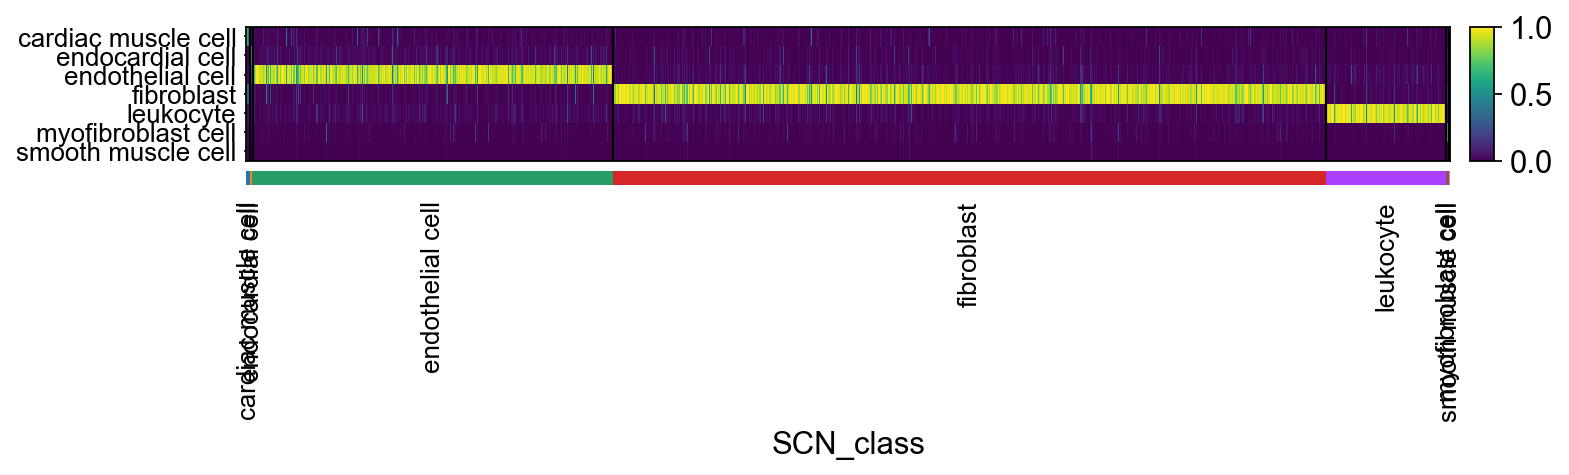

In [64]:
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)

ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

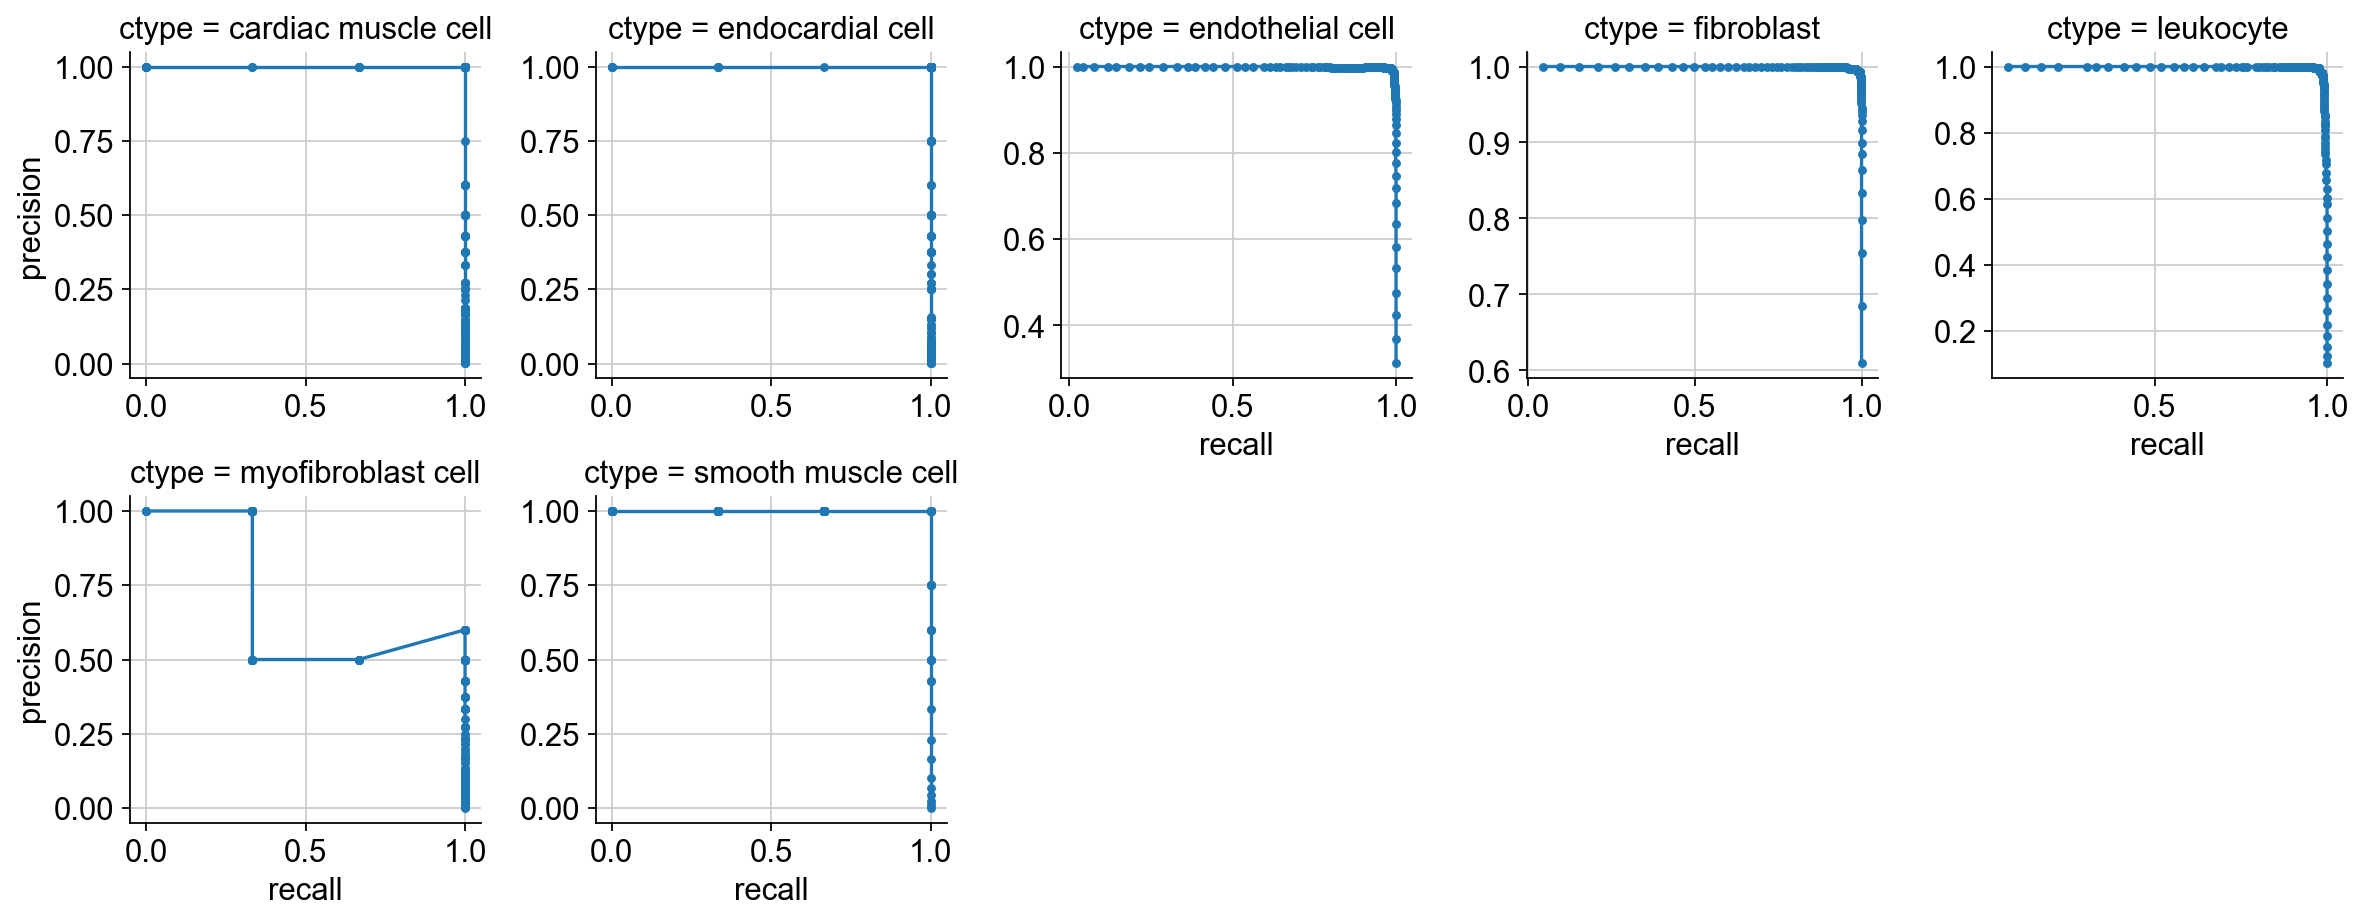

In [65]:
assessment =  pySCN.assess_comm(expTrain, adVal, resolution = 0.005, nRand = 0, dLevelSID = "cell", classTrain = "cell_ontology_class", classQuery = "cell_ontology_class")

pySCN.plot_PRs(assessment)
plt.show()

In [66]:
assessment ['accuracy']

0.9879294336118849

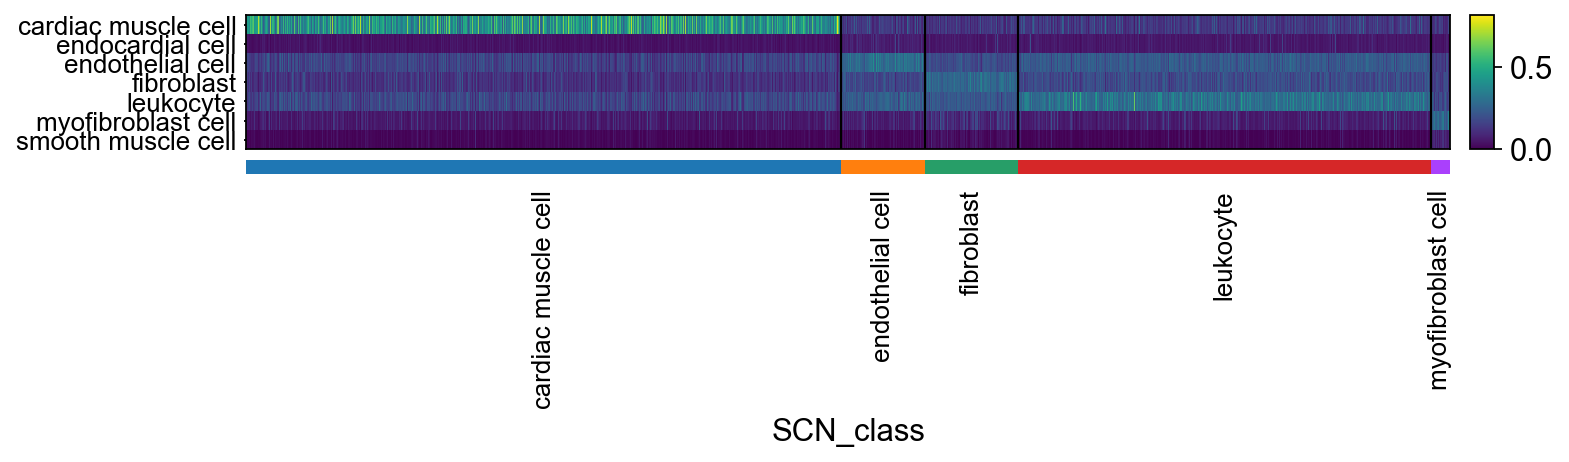

In [67]:
adIPSCM = pySCN.scn_classify(adQuery, cgenesA, xpairs, tspRF, nrand = 0)

ax = sc.pl.heatmap(adIPSCM, adIPSCM.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)

In [68]:
pySCN.add_classRes(adQuery, adIPSCM)

In [69]:
engineered_cardiomyocytes = adQuery[adQuery.obs["SCN_class"] == "cardiac muscle cell"]
engineered_cardiomyocytes.obs

,cardiac muscle cell,endocardial cell,endothelial cell,fibroblast,leukocyte,myofibroblast cell,smooth muscle cell,SCN_class
AAACCTGAGCATCATC-1,0.640,0.015,0.134,0.092,0.082,0.031,0.006,cardiac muscle cell
AAACCTGGTTTCGCTC-1,0.332,0.048,0.142,0.128,0.168,0.137,0.045,cardiac muscle cell
AAACGGGAGCCGCCTA-1,0.390,0.039,0.194,0.129,0.188,0.053,0.007,cardiac muscle cell
AAACGGGGTGAAGGCT-1,0.469,0.033,0.158,0.126,0.144,0.055,0.015,cardiac muscle cell
AAACGGGTCGTCACGG-1,0.605,0.025,0.126,0.082,0.114,0.039,0.009,cardiac muscle cell
...,...,...,...,...,...,...,...,...
TTTGGTTTCTAACGGT-1,0.303,0.077,0.210,0.140,0.218,0.050,0.002,cardiac muscle cell
TTTGGTTTCTCTGAGA-1,0.330,0.047,0.209,0.104,0.260,0.040,0.010,cardiac muscle cell
TTTGGTTTCTGTGCAA-1,0.353,0.077,0.242,0.119,0.158,0.043,0.008,cardiac muscle cell
TTTGTCATCCTACAGA-1,0.508,0.034,0.142,0.098,0.168,0.047,0.003,cardiac muscle cell
